NYU Center for Data Science

DS-GA 1003 Machine Learning

HW4 - Probabilistic models

Stephen Spivack (ss7726@nyu.edu)

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import minmax_scale
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1) Logistic regression

Consider a binary classification setting with input space $X = \mathbb{R}^d$, outcome space $Y_{\pm} = \{−1, 1\}$, and a dataset $D = ((x^{(1)}, y^{(1)}), ..., (x^{(n)}, y^{(n)}))$.

#### Equivalence of ERM and probabilistic approaches

1) Show that the two approaches are equivalent, i.e. they will produce the same solution for $w$.

First, we can write an expression to maximize the log-likelihood in the case of the ERM model:

$\hat{R}_n(w) = \frac{1}{n} \sum_{i=1}^n \ell_{logistic}(y_i w^T x_i) = \frac{1}{n} \sum_{i=1}^n log(1 + e^{-y_i w^T x_i})$

Next, we can write an expression to minimize the negative log-likelihood in the case of the probabilistic model:

$NLL_D(w) = -\sum_{i=1}^n y'_i log(f(w^T x_i)) + (1-y'_i) log(1-f(w^T x_i)) = \sum_{i=1}^n [-y'_i log(f(w^T x_i))] + (y'_i-1) log(1-f(w^T x_i))$

Next, we plug in $y_i \in \{-1,1\}$ to show that both are equal to $\hat{R}_n(w)$:

If $y_i = 1$, then $NLL(w) =  \sum_{i=1}^n [-log(f(w^T x_i))] = \sum_{i=1}^n log(1 + e^{-y_i w^T x_i}) = \hat{R}_n(w)$

If $y_i = -1$, then $NLL(w) =  \sum_{i=1}^n [-log(1 - f(w^T x_i))] = \sum_{i=1}^n log(1 + e^{-y_i w^T x_i}) = \hat{R}_n(w)$

#### Linearly Separable Data

2) Show that the decision boundary of logistic regression is given by $\{x: x^T w = 0\}$. Note that the set will not change if we multiply the weights by some constant $c$.

We model the class probabilities as:

$p(y=1|X) = f(\sum_{i=1}^n w_i x_i) = f(w^T x)$

Given that $f(0) = 0.5$, we conclude that the decision boundary is given by $w^T x = 0$.

3) Suppose the data is linearly separable and by gradient descent/ascent we have reached a decision boundary defined by $\hat{w}$ where all examples are classified correctly. Show that we can always increase the likelihood of the data by multiplying a scalar $c$ on $\hat{w}$, which means that MLE is not well-defined in this case.

The function we are maximizing is given by

$\ell (w) = \sum_{i=1}^n y_i log f(w^T x_i) + (1-y_i) log(1 - f(w^T x_i))$

If $y_i = 1$, we have $\ell (w) = log f(w^T x_i)$. Given the linear separation we know $x_i > 0$, which means $\lim_{w\to\infty} f(w^T x_i) = 0$. The same logic applies for the case where $y_i = -1$.

Therefore, no matter what $cw$ is, we can continually maximize the objective function by increasing $c$ toward infinity.

#### Regularized Logistic Regression

The $\ell_2$ regularized logistic regression objective function can be defined as

$J_{logistic} (w) = \hat{R}_n (w) + \lambda ||w||^2 = \frac{1}{n} \sum_{i=w}^n log(1+ e^{-y_i w^T x_i}) + \lambda||w||^2$.

4) Prove that the objective function $J_{logistic}$ is convex.

We have already proven that both the logistic objective and $\lambda||w||^2$ are convex. Given that the composition of two convex functions is convex, we conclude that $J_{logistic}$ is convex.

5) Complete the `f_objective` function in the skeleton code, which computes the objective function for $J_{logistic} (w)$.

In [2]:
def f_objective(theta, X, y, l2_param=1):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    loss = 0
    for i in range(len(X)):
        loss += np.logaddexp(0, -y[i]*np.dot(theta, X[i]))
    return loss/len(X) + l2_param*np.dot(theta, theta)

6) Complete the `fit_logistic_regression` function in the skeleton code using the `minimize` function from `scipy.optimize`. Use this function to train a model on the provided data. Make sure to take the appropriate preprocessing steps, such as standardizing the data and adding a column for the bias term.

In [3]:
def fit_logistic_reg(X, y, objective_function, l2_param=1):
    '''
    Args:
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        objective_function: function returning the value of the objective
        l2_param: regularization parameter
        
    Returns:
        optimal_theta: 1D numpy array of size num_features
    '''
    part_obj = partial(objective_function, X=X, y=y, l2_param=l2_param)
    return minimize(part_obj, np.ones(X.shape[1])).x

In [4]:
def load_data():
    X_train = np.loadtxt('X_train.txt', dtype=float, encoding=None, delimiter=',')
    X_test = np.loadtxt('X_val.txt', dtype=float, encoding=None, delimiter=',')
    y_train = np.loadtxt('y_train.txt', dtype=float, encoding=None, delimiter=',').reshape(-1,1)
    y_test = np.loadtxt('y_val.txt', dtype=float, encoding=None, delimiter=',').reshape(-1,1)
    return X_train, X_test, y_train, y_test

In [5]:
def preprocess_data(X_train, X_test, y_train, y_test):
    X_train = stats.zscore(X_train, axis=1)
    X_test = stats.zscore(X_test, axis=1)
    X_train = np.concatenate((X_train, np.ones(len(X_train)).reshape(-1,1)), axis=1)
    X_test = np.concatenate((X_test, np.ones(len(X_test)).reshape(-1,1)), axis=1)
    y_train[y_train==0] = -1
    y_test[y_test==0] = -1
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = load_data()
X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test, y_train, y_test)
optimal_theta = fit_logistic_reg(X_train, y_train, f_objective, l2_param=1)
optimal_theta

array([-0.00308146, -0.00452418, -0.00506516,  0.13665768, -0.00890677,
       -0.00511805, -0.00791663, -0.00385607, -0.00704975, -0.02800517,
        0.00225178, -0.00864217,  0.00543885, -0.00809036, -0.00679931,
       -0.00152705, -0.00629847, -0.01327318, -0.01021308, -0.01595948,
        0.00439617])

7) Find the $\ell_2$ regularization parameter that minimizes the log-likelihood on the validation set. Plot the log-likelihood for different values of the regularization parameter.

In [7]:
def log_likelihood(theta, X, y):
    loss = 0
    for i in range(len(X)):
        loss += np.logaddexp(0, -y[i]*np.dot(theta, X[i]))
    return -loss

In [8]:
reg_params = np.geomspace(0.0001, 1, 100)
loss = []
for i in range(len(reg_params)):
    theta = fit_logistic_reg(X_train, y_train, f_objective, l2_param=reg_params[i])
    loss.append(log_likelihood(theta, X_test, y_test))

Optimal lambda: 0.02915053062825179


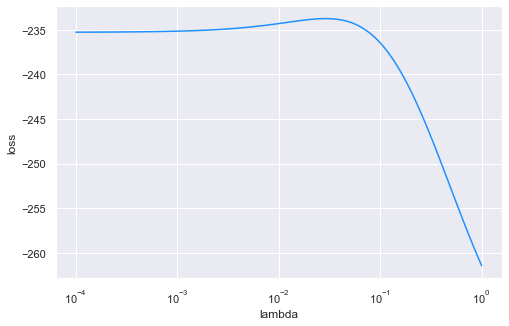

In [9]:
print('Optimal lambda:', float(reg_params[np.argmax(loss)]))
plt.figure(figsize=(8,5))
plt.plot(reg_params, loss, color='dodgerblue')
plt.ylabel('loss')
plt.xlabel('lambda')
plt.xscale('log')
plt.show()

8) It seems reasonable to interpret the prediction $f(x)=\phi(w^Tx)=\frac{1}{(1+e^{−w^Tx})}$ as the probability that $y = 1$, for a randomly drawn pair $(x, y)$. Since we only have a finite sample (and we are regularizing, which will bias things a bit) there is a question of how well “calibrated” our predicted probabilities are. Roughly speaking, we say $f(x)$ is well calibrated if we look at all examples $(x,y)$ for which $f(x) ≈ 0.7$ and we find that close to 70 percent of those examples have $y = 1$, as predicted... and then we repeat that for all predicted probabilities in $(0, 1$). To see how well-calibrated our predicted probabilities are, break the predictions on the validation set into groups based on the predicted probability (you can play with the size of the groups to get a result you think is informative). For each group, examine the percentage of positive labels. You can make a table or graph. Summarize the results.

In [10]:
optimal_theta = fit_logistic_reg(X_train, y_train, f_objective, l2_param=0.029)
pred = np.dot(X_test, optimal_theta)
for i in range(len(pred)):
    pred[i] = 1/(1 + np.exp(-pred[i]))
pred = minmax_scale(pred)
frac_pos, mean_pred = calibration_curve(y_test, pred, n_bins=10)

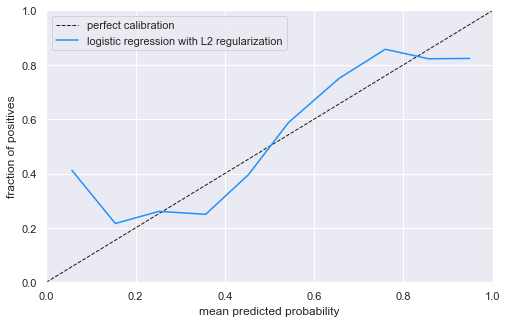

In [11]:
plt.figure(figsize=(8,5))
plt.plot([0,1], [0,1], ls='--', lw=1, color='k', label='perfect calibration')
plt.plot(mean_pred, frac_pos, color='dodgerblue', label='logistic regression with L2 regularization')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('mean predicted probability')
plt.ylabel('fraction of positives')
plt.legend()
plt.show()

### 2) Coin flipping with partial observability

Consider flipping a biased coin where $p(z=H | \theta_1) = \theta_1$. However, we cannot directly observe the result $z$. Instead, someone reports the results to us, which we denote by $x$. Further there is a chance that the result is reported incorrectly if it's a head. Specifically, we have $p(x=H|z=H,\theta_2)=\theta_2$ and $p(x=T|z=T)=1$.

9) Show that $p(x=H | \theta_1, \theta_2) =  \theta_1 \theta_2$.

$P(x=H|\theta_1,\theta_2)= P(z=H|\theta_1)P(x=H|z=H,\theta_2)+P(z=T|\theta_1)P(x=H|z=T,\theta_2)= \theta_1\theta_2+(1-\theta_1)*0= \theta_1\theta_2$.

10) Given a set of reported results $D_r$ of size $N_r$, where the number of heads is $n_h$ and the number of tails is $n_t$, what is the likelihood of $D_r$ as a function of $\theta_1$ and $\theta_2$.

$p(x=H | \theta_1, \theta_2) =  \theta_1 \theta_2$

$p(x=T | \theta_1, \theta_2) =  1 - \theta_1 \theta_2$

$P(D_r|\theta_1,\theta_2)=\prod_{i=1}^{N_r}P(x=X|z=Z)P(z=Z) = (\theta_1\theta_2)^{n_h}(1-\theta_1\theta_2)^{n_t}$

11) Can we estimate $\theta_1$ and $\theta_2$ using MLE? Explain your judgment.

No, because the likelihood we observe will not allow us to estimate $\theta_1$ and $\theta_2$. The partial derivatives are not solvable for a single parameter. We cannot use MLE to estimate $\theta_1$ and $\theta_2$.